The notebook demonstrate most of the data analysis work of my thesis titled "Maximize Group Thermal Comfort in Occupant-based Control by Learning Individual Thermal Profiles".  The data collected from controlled experiments has been pre-prossessed by removing noises, filling the missing data and  so on.  
The work mainly comprised of three parts: exploratory data analysis, individual thermal profiles and group negotiation.

In [0]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [0]:
!pip install --upgrade -q gspread
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import gspread
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


## Load processed experiment data

In [0]:
user_num = [1,2,3,4,5,6]
users = ['user%d'%i for i in user_num]
user_titles, user_ids = {}, {}
for user in users:
    prefix = 'data-'+user
    user_data = drive.ListFile({'q': "title contains '.csv' and title contains '%s'"%prefix}).GetList()
    user_titles[user] = [file['title'] for file in user_data]
    user_ids[user] = [file['id'] for file in user_data]

env_data = drive.ListFile({'q': "title contains '.csv' and title contains 'environment-'"}).GetList()
env_titles = [file['title'] for file in env_data]
env_ids = [file['id'] for file in env_data]
env_dict = {env_titles[i]:env_ids[i] for i in range(len(env_titles))}

In [0]:
user_data = {}
for user in users:
    all_data = []
    for i, ID in enumerate(user_ids[user]):
        downloaded = drive.CreateFile({'id': ID})
        downloaded.GetContentFile(user_titles[user][i])
        data = pd.read_csv(user_titles[user][i], sep=',', header='infer', parse_dates=[0], infer_datetime_format=True)
        outdoor_name = user_titles[user][i].replace('data-'+user, 'environment-outdoor')
        try:
            downloaded = drive.CreateFile({'id': env_dict[outdoor_name]})
            downloaded.GetContentFile(outdoor_name)
            outdoor = pd.read_csv(outdoor_name, sep=',', header=None, names=['Time','Temperature','RH'],
                          parse_dates=[0], infer_datetime_format=True)
        except:
            print('Error: no corresponding outdoor file')
        out_average = pd.DataFrame(np.array([outdoor[['Temperature', 'RH']][(outdoor['Time']>t-dt.timedelta(minutes=30)) & 
                                                                            (outdoor['Time']<t)].median() for t in data['Time']]), 
                                   columns=['Outdoor_T (C)','Outdoor_RH (%)'])
        all_data.append(pd.concat([data, out_average], axis=1))
    user_data[user] = all_data

In [0]:
df = {}
for user in users:
    df[user] = pd.concat(user_data[user], axis=0).reset_index(drop=True).fillna(method='ffill')

*  `Sensation` and `Satisfaction` are thermal votes collected from participants. 
*  `Temperature (C)` and `RH (%)` are the average indoor tempearture and relative humidity in the 3-minute period before each vote.   
*  `Outdoor_T (C)` and `Outdoor_RH (%)` are the average outdoor tempearture and relative humidity in the 30-minute period before each vote.  
*  `T_trend` is a calculated indicator for temperature changing trend (-1 for decreasing, 1 for increasing and 0 for almost constant), and `T_diff` is the temperature difference in 10 minutes before each vote



In [7]:
df['user1'].describe()

,Sensation,Satisfaction,Temperature (C),RH (%),T_trend,T_diff,Outdoor_T (C),Outdoor_RH (%)
count,215.000000,215.000000,215.000000,215.000000,215.00000,215.000000,215.000000,215.000000
mean,0.469767,-0.167442,24.094372,27.480070,0.00000,-0.017907,12.058605,41.037070
std,1.376630,1.660385,2.810548,7.125861,0.80883,0.589803,4.491493,20.656603
min,-3.000000,-3.000000,19.120000,18.550000,-1.00000,-1.400000,2.800000,20.000000
25%,-1.000000,-2.000000,22.070000,21.320000,-1.00000,-0.400000,10.200000,23.605000
50%,0.000000,0.000000,24.100000,25.320000,0.00000,0.100000,10.800000,31.060000
75%,1.000000,1.000000,26.400000,34.125000,1.00000,0.400000,15.800000,52.575000
max,3.000000,3.000000,30.400000,40.700000,1.00000,1.600000,20.600000,79.200000


## Exploratory Data Analysis

**Violin plots to show the sensation distribution under different tempeartures of different users  
User6 is less sensitive and user2 has lower tolerance for warm temperature**

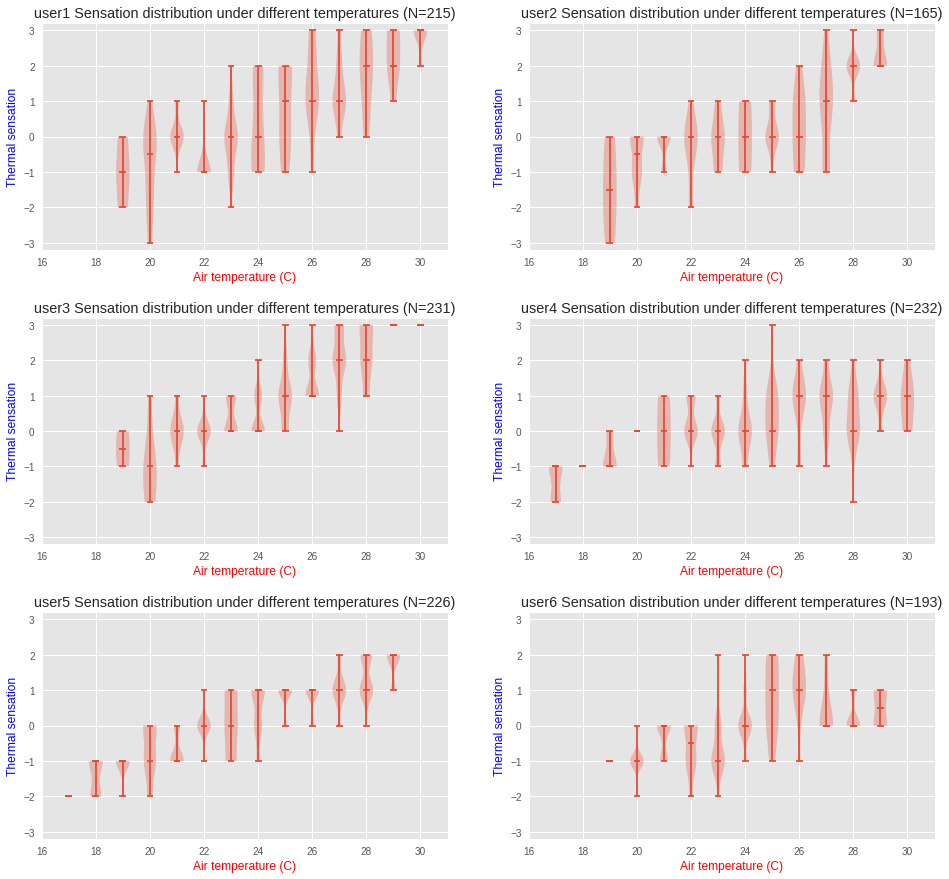

In [93]:
fig, axes = plt.subplots(3,2, figsize=(16,15))
plt.subplots_adjust(hspace = 0.3)
for i, user in enumerate(users):
    pos = []
    violin = []
    for group in df[user].round(0).groupby(by='Temperature (C)'):
        pos.append(group[0])
        violin.append(np.array(group[1]['Sensation']))

    ax = axes[i//2, i%2]
    ax.violinplot(violin, pos, widths=0.5,showmeans=False, showextrema=True, showmedians=True)
    ax.set_title(user+' Sensation distribution under different temperatures (N=%d)'%len(df[user]))
    ax.set_ylabel('Thermal sensation', color='b', fontsize=12)
    ax.set_xlabel('Air temperature (C)', color = 'r', fontsize=12)
    ax.set_xlim(16, 31)
    ax.set_ylim(-3.2, 3.2)

**Thermal satisfaction doesn't follow thermal sensation perfectly. Many confounding factors affect satisfaction, such as non-uniform sensation**

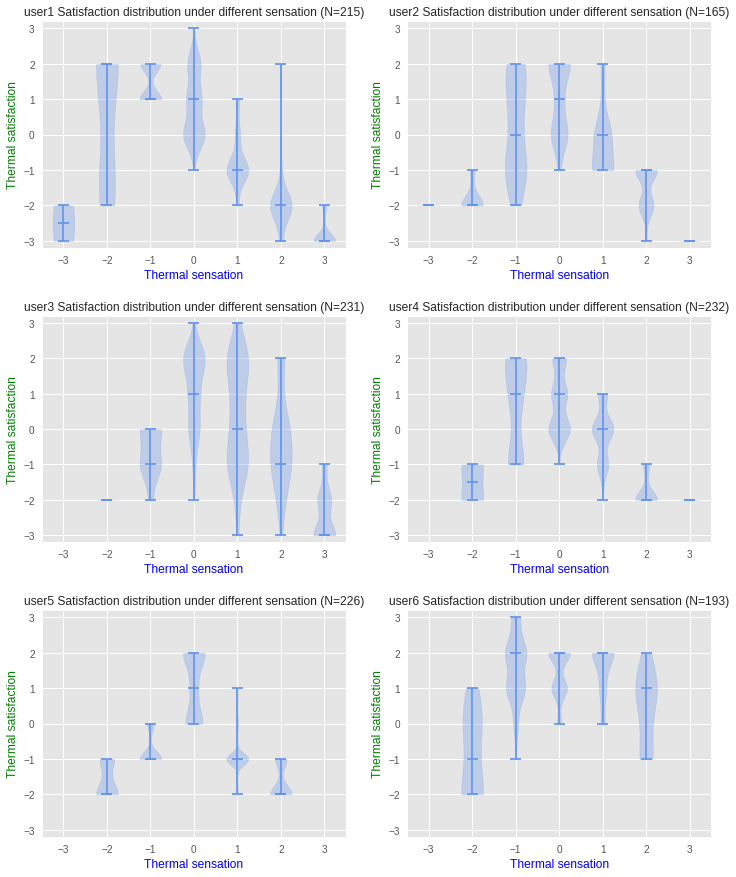

In [103]:
fig, axes = plt.subplots(3,2, figsize=(12,15))
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
for i,user in enumerate(users):
    pos = []
    violin = []
    for group in df[user].groupby(by='Sensation'):
        pos.append(group[0])
        violin.append(np.array(group[1]['Satisfaction']))
    ax = axes[i//2, i%2]
    violin_parts = ax.violinplot(violin, pos, widths=0.5,showmeans=False, showextrema=True, showmedians=True)
    for pc in violin_parts['bodies']:
        pc.set_facecolor('cornflowerblue')
        pc.set_edgecolor('cornflowerblue')
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('cornflowerblue')
    ax.set_title(user+' Satisfaction distribution under different sensation (N=%d)'%len(df[user]), fontsize=12)
    ax.set_ylabel('Thermal satisfaction', color='g', fontsize=12)
    ax.set_xlabel('Thermal sensation', color = 'b', fontsize=12)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.2, 3.2)

**Under the same temperature, people tend to feel warmer when temperature is increasing than decreasing  
(response lag for changing from neutral to non-neutral condition)**

In [0]:
import matplotlib.patches as mpatches

In [0]:
L = [df[user] for user in users]
data_all = pd.concat(L, axis=0).reset_index(drop=True)

(-3.2, 3.2)

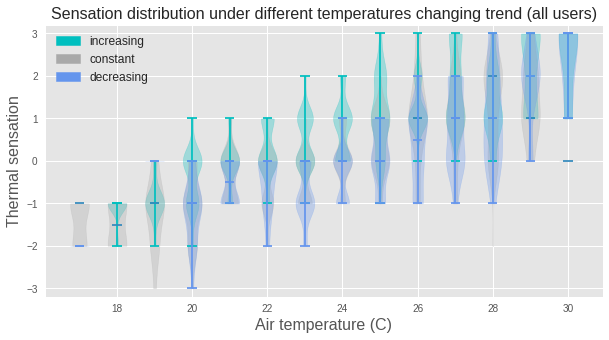

In [110]:
pos_u, pos_d, pos_n = [], [], []
violin_u, violin_d, violin_n = [], [], []
user_d = data_all[data_all["T_trend"] == -1].fillna(method='backfill').round(0)
user_u = data_all[data_all["T_trend"] == 1].fillna(method='backfill').round(0)
user_n = data_all[data_all["T_trend"] == 0].fillna(method='backfill').round(0)
for group in user_u.groupby(by='Temperature (C)'):
    pos_u.append(group[0])
    violin_u.append(np.array(group[1]['Sensation']))
for group in user_d.groupby(by='Temperature (C)'):
    pos_d.append(group[0])
    violin_d.append(np.array(group[1]['Sensation']))
for group in user_n.groupby(by='Temperature (C)'):
    pos_n.append(group[0])
    violin_n.append(np.array(group[1]['Sensation']))
fig, ax1 = plt.subplots(figsize=(10,5))
violin_parts_u = ax1.violinplot(violin_u, pos_u, widths=0.5,showmeans=False, showextrema=True, showmedians=True)
violin_parts_n = ax1.violinplot(violin_n, pos_n, widths=0.5,showmeans=False, showextrema=False, showmedians=True)
violin_parts_d = ax1.violinplot(violin_d, pos_d, widths=0.5,showmeans=False, showextrema=True, showmedians=True)
patch1 = mpatches.Patch(color='c')
patch2 = mpatches.Patch(color='darkgray')
patch3 = mpatches.Patch(color='cornflowerblue')
fake_handles = [patch1, patch2, patch3]
labels = ['increasing', 'constant', 'decreasing']
ax1.legend(fake_handles, labels, loc=2, prop={'size': 12})

for pc in violin_parts_u['bodies']:
    pc.set_facecolor('c')
    pc.set_edgecolor('c')
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts_u[partname]
    vp.set_edgecolor('c')
for pc in violin_parts_n['bodies']:
    pc.set_facecolor('darkgray')
    pc.set_edgecolor('darkgray')
for pc in violin_parts_d['bodies']:
    pc.set_facecolor('cornflowerblue')
    pc.set_edgecolor('cornflowerblue')
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts_d[partname]
    vp.set_edgecolor('cornflowerblue')
    
ax1.set_title('Sensation distribution under different temperatures changing trend (all users)', fontsize=16)
ax1.set_ylabel('Thermal sensation', fontsize=16)
ax1.set_xlabel('Air temperature (C)', fontsize=16)
# ax1.set_xlim(16, 31)
ax1.set_ylim(-3.2, 3.2)

## Build individual thermal profiles


*  **Predict sensation / satisfaction / a combined metirc**  
The accuracy is largely decreased when predicting thermal satisfaction than thermal sensation, which indicates the loose correlation between environmental data and thermal satisfaction. If the satisfaction/dissatisfaction is not caused by environmental factors used in the model, it’s useless to adjust the temperature setpoint. Since there’s indeed a gap between thermal sensation and satisfaction, a composited metric for a comprehensive consideration of thermal sensation and satisfaction is proposed.  
The absolute value of the 7-scale thermal sensation can generally reflect the comfort level, with a larger value indicating less comfort. Besides, larger value of the 7-scale satisfaction corresponds to a higher comfort level. Therefore, the new metric for evaluating thermal comfort is defined as follows:
*`m= satisfaction-|sensation|, where sensation∈[-3,3], satisfaction∈[-3,3]`*  
m ranges from -6 to 3, with a lager value indicating higher comfort. Then the metric will be further classified into 5 comfort level with a bin size of 2.  So the final metric for thermal comfort will be 5-scale (1-5).

*  **Compare 5 machine learning models (Random Forest, KNN Logistic Regression, Gradient Boosting, SVM)**
*  **Test whether temperature changing trend is an effective feature**
*  **Possible feature reduction**


In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from numpy.random import permutation
from sklearn.model_selection import train_test_split

In [0]:
def cv(df, clfs, feature_names, label_name, k=5, random_seed=0):
    # df: the dictionary contaions dataframes for all users
    # clfs: dictionary of classifiers
    # k: number of folders for cross validation
    # feature_names: list of feature names in df
    # label_name: string of label name in df
    users = list(df.keys())
    con_names = []
    disc_names = []
    for name in feature_names:
        if df[users[0]][name].dtype == np.float:
            con_names.append(name)
        else:
            disc_names.append(name)
    accuracys = {}
    for key in clfs:
        accuracys[key] = np.zeros(len(users)+1)  
    for j, user in enumerate(users):
        con_features = df[user][con_names]
        disc_features = df[user][disc_names]
        if label_name in df[user].columns:
            labels = df[user][label_name]
        else: # calculate the combined comfort metric
            L = df[user]['Satisfaction']-abs(df[user]['Sensation'])
            labels = pd.Series([1 if x<=-5 else 2 if x<=-3 else 3 if x<=-1 else 4 if x<=1 else 5 for x in L])
        n = len(labels)
        np.random.seed(random_seed)
        idx_shuffle = permutation(n)
        idx_all = set(idx_shuffle)
        for i in range(k):
            idx_val = idx_shuffle[n//k*i:n//k*(i+1)]
            idx_train = list(idx_all-set(idx_val))
            X_train_c = con_features.iloc[idx_train]
            X_train_d = disc_features.iloc[idx_train]
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train_c)
            if list(X_train_d.columns):
                X_train = np.hstack((X_train, np.array(X_train_d).reshape(X_train_d.shape[0], len(X_train_d.columns))))
            y_train = labels.iloc[idx_train]
            X_val_c = con_features.iloc[idx_val]
            X_val_d = disc_features.iloc[idx_val]
            X_val = scaler.transform(X_val_c)
            if list(X_val_d.columns):
                X_val = np.hstack((X_val, np.array(X_val_d).reshape(X_val_d.shape[0], len(X_val_d.columns))))
            y_val = labels.iloc[idx_val]
            for clf in clfs:
                clfs[clf].fit(X_train, y_train)
                pred = clfs[clf].predict(X_val)
                accuracys[clf][j] += (pred == y_val).sum()
        for clf in accuracys:
            accuracys[clf][j] /= n//k*k
    # calculate the average of the accuracy of all users
    for clf in accuracys:
        numbers = 0
        for i,user in enumerate(users):
            accuracys[clf][-1] += accuracys[clf][i]*(len(df[user])//5*5)
            numbers += len(df[user])//5*5
        accuracys[clf][-1] /= numbers
    return accuracys

In [0]:
forest = RandomForestClassifier(n_estimators = 50, class_weight='balanced', random_state=0)
neigh = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression(C=1e4, penalty='l1', random_state=0)
grb = GradientBoostingClassifier(n_estimators=50,learning_rate=0.2, random_state=0)
svm = SVC(kernel='rbf', C=1.5, random_state=0)
clfs = {'random forest': forest, 'knn':neigh, 'logistic regression':logreg, 'gradient boosting':grb, 'SVM':svm}

feature_names = ['Temperature (C)', 'RH (%)', 'Outdoor_T (C)', 'Outdoor_RH (%)', 'T_trend']
label_name = 'other'
acc_combine = cv(df, clfs, feature_names, label_name, k=5)

Generally Random Forest performs best among all users.  
(The accuracy can achieve 70% for most of participants by predicting thermal sensation and only around 60% by predicting thermal satisfaction)

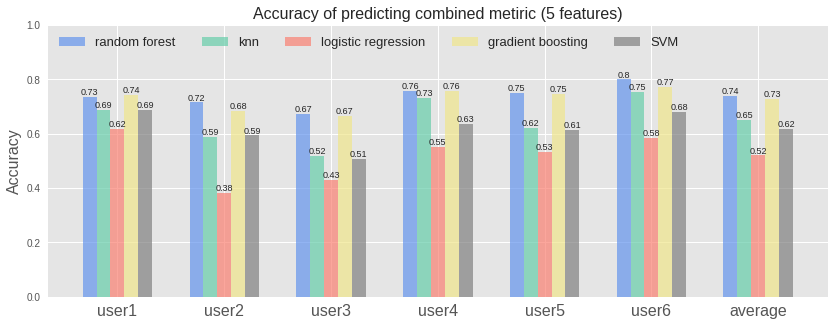

In [135]:
index = np.arange(len(users)+1)
bar_width = 0.13
plt.figure(figsize=(14,5))
colors = ['cornflowerblue', 'mediumaquamarine', 'salmon', 'khaki', 'gray']
rects = {}
for i, key in enumerate(acc_combine):
    rects[key] = plt.bar(index+i*bar_width, acc_combine[key], bar_width,color=colors[i],alpha=0.7,label=key)
plt.xticks(index + bar_width*2, users+['average'], fontsize=16)
plt.legend(ncol=5, loc="upper left", prop={'size': 13})
plt.ylim(0,1)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy of predicting combined metiric (5 features)', fontsize=16)
for key in rects:
    for i in range(len(rects[key])):
        rect = rects[key][i]
        height = rect.get_height()
        label = round(acc_combine[key][i],2)
        plt.text(rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom', fontsize=9)

In [0]:
import seaborn as sns

In [0]:
def featureImportance(df, feature_names):
    users = list(df.keys())
    forest = RandomForestClassifier(n_estimators = 50, class_weight='balanced')
    con_names = []
    disc_names = []
    for name in feature_names:
        if df[users[0]][name].dtype == np.float:
            con_names.append(name)
        else:
            disc_names.append(name)
    importance = np.zeros((len(users), len(feature_names)))
    for i, user in enumerate(users):
        con_features = df[user][con_names]
        disc_features = df[user][disc_names]
        L = df[user]['Satisfaction']-abs(df[user]['Sensation'])
        y = pd.Series([1 if x<=-5 else 2 if x<=-3 else 3 if x<=-1 else 4 if x<=1 else 5 for x in L])
        scaler = StandardScaler()
        X = scaler.fit_transform(con_features)
        if list(disc_features.columns):
            X = np.hstack((X, np.array(disc_features).reshape(disc_features.shape[0], len(disc_features.columns))))
        forest.fit(X, y)
        importance[i] = forest.feature_importances_
    return importance

From the feature importance of Random Forest model, temperature changing trend is not an effective feature, and other environmental features are all important to predict thermal comfort.

Text(0.5,1,'Feature importance of Random Forest model')

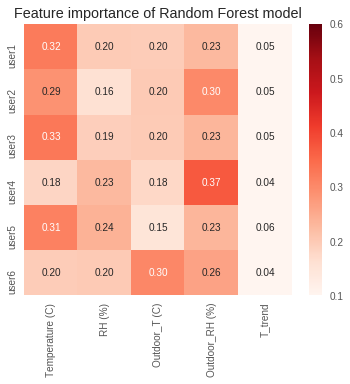

In [124]:
importances = featureImportance(df, feature_names)
plt.figure(figsize=(6,5))
ax = sns.heatmap(importances, annot=True,fmt='.2f', cmap='Reds',vmin=0.1, vmax=0.6,
                xticklabels=feature_names,
                yticklabels = users)
ax.set_title('Feature importance of Random Forest model')

Calculate Pearson correlation and Distance correlation to explore the linear correlation and dependency between features.

In [130]:
from scipy.stats import pearsonr
!pip install dcor
import dcor

    100% |████████████████████████████████| 1.9MB 3.7MB/s 
    100% |████████████████████████████████| 15.8MB 1.9MB/s 


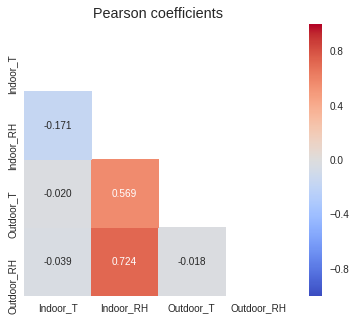

In [128]:
features = data_all[['Temperature (C)', 'RH (%)','Outdoor_T (C)', 'Outdoor_RH (%)']]
f_num = len(features.columns)
pearsons = np.zeros((f_num, f_num))
for i in range(f_num):
    for j in range(i):
        pcoeff, p_value = pearsonr(features[features.columns[i]], features[features.columns[j]])
        pearsons[i,j] = pcoeff

plt.figure(figsize=(6,5))
mask = np.zeros_like(pearsons)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(pearsons, annot=True,fmt='.3f', mask=mask, cmap='coolwarm',vmin=-1, vmax=1,
                    xticklabels=['Indoor_T', 'Indoor_RH', 'Outdoor_T', 'Outdoor_RH'],
                    yticklabels = ['Indoor_T', 'Indoor_RH', 'Outdoor_T', 'Outdoor_RH'])
    ax.set_title('Pearson coefficients')

/usr/local/lib/python3.6/dist-packages/dcor/_utils.py:88: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return ((np.issubdtype(x.dtype, float) and


Text(0.5,1,'Distance coefficients')

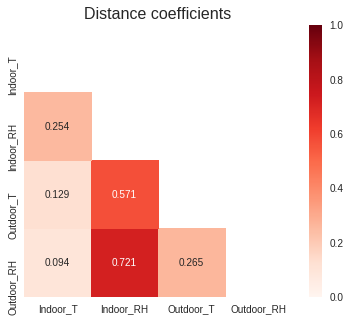

In [132]:
dCor = np.zeros((f_num, f_num))
for i in range(f_num):
    for j in range(i):
        dCor[i,j] = dcor.distance_correlation(features[features.columns[i]], features[features.columns[j]])
plt.figure(figsize=(6,5))
mask = np.zeros_like(dCor)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(dCor, annot=True,fmt='.3f', mask=mask, cmap='Reds',vmin=0, vmax=1,
                    xticklabels=['Indoor_T', 'Indoor_RH', 'Outdoor_T', 'Outdoor_RH'],
                    yticklabels = ['Indoor_T', 'Indoor_RH', 'Outdoor_T', 'Outdoor_RH'])
ax.set_title('Distance coefficients', fontsize=16)

A strong linear correlation between outdoor RH and indoor RH can be observed. This suggests that the indoor RH can be removed and the performance of the model probably won’t be hurt much. The prediction accuracy of Random Forest model is compared below.

In [0]:
feature_names = ['Temperature (C)', 'Outdoor_T (C)', 'Outdoor_RH (%)']
label_name = 'other'
acc_3 = cv(df, clfs, feature_names, label_name, k=5)

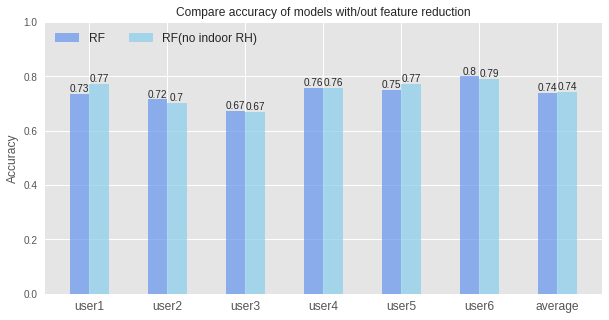

In [140]:
index = np.arange(len(users)+1)
bar_width = 0.25
plt.figure(figsize=(10,5))
rects_rf = plt.bar(index, acc_combine['random forest'],bar_width,color='cornflowerblue',alpha=0.7,label='RF')
rects_rf_2 = plt.bar(index+bar_width, acc_3['random forest'],bar_width,color='skyblue',alpha=0.7,label='RF(no indoor RH)')

plt.xticks(index + bar_width/2, users+['average'], fontsize=12)
plt.legend(ncol=2, loc="upper left", prop={'size': 12})
plt.ylim(0,1)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Compare accuracy of models with/out feature reduction', fontsize=12)
for i in range(len(rects_rf)):
    rect_rf = rects_rf[i]
    height_rf = rect_rf.get_height()
    label_rf = round(acc_combine['random forest'][i],2)
    plt.text(rect_rf.get_x() + rect_rf.get_width() / 2, height_rf, label_rf,
            ha='center', va='bottom')
    rect_rf_2 = rects_rf_2[i]
    height_rf_2 = rect_rf_2.get_height()
    label_rf_2 = round(acc_3['random forest'][i],2)
    plt.text(rect_rf_2.get_x() + rect_rf_2.get_width() / 2, height_rf_2, label_rf_2,
            ha='center', va='bottom')

## Negotiation: Optimal setpoint algorithm

Use Random Forest model to build individual thermal profiles to predict the comfort level (proposed above) of each occupant under some environmental conditions

In [0]:
acc_rf = []
clfs = {}
scalers = {}
for i,user in enumerate(users):
    forest = RandomForestClassifier(n_estimators = 50, class_weight='balanced', random_state=46)
    features = df[user][['Temperature (C)', 'RH (%)', 'Outdoor_T (C)', 'Outdoor_RH (%)']]
    L = df[user]['Satisfaction']-abs(df[user]['Sensation'])
    labels = pd.Series([1 if x<=-5 else 2 if x<=-3 else 3 if x<=-1 else 4 if x<=1 else 5 for x in L])
    scaler = StandardScaler()
    scaler.fit(features)
    scalers[user] = scaler
    X = scaler.transform(features)
    forest.fit(X, labels)
    clfs[user] = forest

With indoor RH of 25%, outdoor RH of 35% and outdoor temperature of 10 (℃), comfort index of each occupant when indoor temperature setpoint varies from 18℃ to 32℃ is shown as follows.

In [0]:
RH_i = 25.0
RH_o = 35.0
T_o = 10
Sen = {}
for user in users:
    Sen[user] = []
    for T_in in range(18, 33):
        feature = scalers[user].transform(np.array([T_in, RH_i, T_o, RH_o])[None,:])
        Sen[user].append(clfs[user].predict(feature)[0])

(0.8, 5.2)

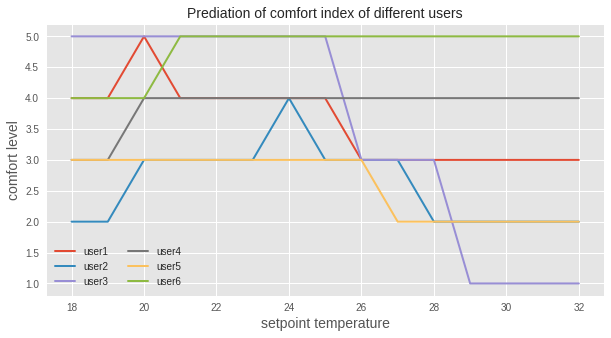

In [188]:
T = np.array(range(18, 33))
plt.subplots(figsize=(10,5))
for user in users:
    plt.plot(T, Sen[user], label=user, linewidth=2.0)
plt.xlabel('setpoint temperature', fontsize=14)
plt.ylabel('comfort level', fontsize=14)
plt.title('Prediation of comfort index of different users', fontsize=14)
plt.legend(ncol=2)
plt.ylim(0.8,5.2)

The algorithm will do an exhaustive search in a temperature range and choose the setpoint that maximizes the total thermal comfort index of the group. To take the thermal sensitivity of different occupants, the comfort index of each occupant will be weighted. 

In [0]:
def optimal_setpoint(RH_i, T_o, RH_o, clfs, scalers, users=users):
    comf_index_max = 0
    unweighted_comfort_max = 0
    t_set = None
    comfort = {}
    for user in users:
        comfort[user] = []
        for T_in in range(18, 33):
            feature = scalers[user].transform(np.array([T_in, RH_i, T_o, RH_o])[None,:])
            comfort[user].append(clfs[user].predict(feature)[0])
    weights = {}
    for user in users:
        weights[user] = sum(comfort[user])
    for T_in in range(18, 33):
        comf_index = 0
        unweighted_comfort = 0
        for user in users:
            comf = comfort[user][T_in-18]
            comf_index += 1/weights[user]*comf
            unweighted_comfort += comf
        if comf_index > comf_index_max:
            comf_index_max = comf_index
            unweighted_comfort_max = unweighted_comfort
            t_set = T_in
    return t_set, unweighted_comfort_max/len(users)

Under this conditions, the optimal setpoint searched by the algorithm when the outdoor temperature varies from 2℃-18℃ is shown below.

In [0]:
RH_i = 25.0
RH_o = 35.0
setpoint = []
comfort = []
for T_o in range(2,18):
    t, comfort_index = optimal_setpoint(RH_i, T_o, RH_o, clfs, scalers)
    setpoint.append(t)
    comfort.append(comfort_index)

In [190]:
setpoint

[20, 20, 20, 20, 20, 20, 20, 20, 24, 25, 25, 25, 25, 25, 24, 21]

In [191]:
comfort

[3.8333333333333335,
 3.8333333333333335,
 3.8333333333333335,
 3.8333333333333335,
 3.8333333333333335,
 3.8333333333333335,
 4.0,
 4.0,
 4.166666666666667,
 3.6666666666666665,
 3.6666666666666665,
 3.6666666666666665,
 3.6666666666666665,
 3.6666666666666665,
 3.8333333333333335,
 3.8333333333333335]

Text(0,0.5,'Average comfort level')

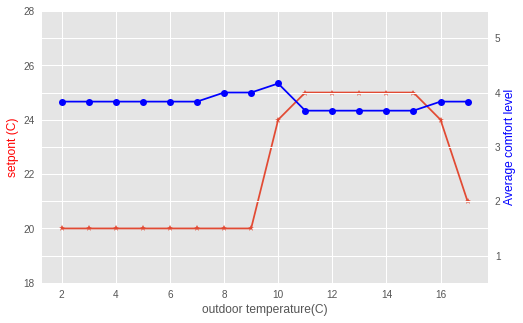

In [193]:
fig, ax1 = plt.subplots(figsize=(8,5))
x = np.array(list(range(2,18)))
ax1.plot(x, np.array(setpoint), '*-', label='setpoint')
ax1.set_ylabel('setpont (C)', color='r')
ax1.set_ylim((18,28))
ax1.set_xlabel('outdoor temperature(C)')
ax2 = ax1.twinx()
ax2.plot(x, np.array(comfort), 'o-', color='b',label='Average comfort level')
ax2.set_ylim((0.5,5.5))
ax2.set_ylabel('Average comfort level', color='b')